# Code sample for CU Earth Lab Data Scientist Position  <a name="top"></a>
By: Chilisa Shorten (cmshorten@gmail.com)<br /> 
May 31, 2021

**This work represents provisional interpretations, please do not distribute.**

**Code Context:**<br />
This code represents a type of data I work with (ICP-MS data from mudstone samples) and statistical/machine learning methods which I commonly use. The script contains documentation within the function and markdown cells, which explain the processes so that others can understand and reproduce the same results. This script is capable of being applied to other datasets if the user structures the input file like the example (i.e. "Unit" column and three elements of interest) and provides <span style="color:red;font-weight:bold">!!! INPUT !!!</span> when prompted.

**Data Context:**<br />
The dataset in this example is from one study area with samples from two different units, the Mordecai and Rigby units (names changed to Regular Show cartoon characters due to the provisional nature of the data). The data are elemental amounts of potassium (K %), uranium (U ppm), and thorium (Th pmm) in mudstone samples. Samples were collected, ground, and analyzed for elements using ICP-MS. We are interested in determining if there are clusters within each unit – which may explain the variation of the unit across the study area – and examining how the three elements relate to each other.

**Table of Contents:**
1. [Import Libraries and Set Display Options](#1)
2. [Load, Describe and Visualize](#2)
    1. [Load](#2a)
    2. [Describe](#2b)
    3. [Visualize](#2c)
3. [Cluster the data](#3)
    1. [Determine the best number of clusters](#3a)
    2. [Run KMeans Clustering](#3b)
4. [Examine and Interpret Clusters](#4)
    1. [Examine clustering](#4a)
    2. [PCA to examine feature importance](#4b)
5. [Conclusions](#5)

## 1. Import Libraries and Set Display Options <a name="1"></a>

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

# PCA
from sklearn.decomposition import PCA

In [2]:
# set column and row display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)

## 2. Load, Describe and Visualize <a name="2"></a>
[back to top](#top)
### 2a. Load <a name="2a"></a>

<span style="color:red;font-weight:bold">!!! INPUT !!!</span>

Save 'Dummy_ICP_Data_Mordecai_Rigby_UThK.xlsx' and copy the absolute file path, including the root of the drive. Put your file path in the code block below and make sure to include **r** before the parenthesis.

Example: r'C:\Users\cshorten\OneDrive - DOI\Python\AK\Dummy_ICP_Data_Mordecai_Rigby_UThK.xlsx'

In [3]:
file = r'C:\Users\cshorten\OneDrive - DOI\Python\AK\Dummy_ICP_Data_Mordecai_Rigby_UThK.xlsx'

In [4]:
df = pd.read_excel(file)

In [5]:
df

K %  U ppm  Th ppm      Unit
0    4.5   21.1    13.1     Rigby
1    3.9   24.5    17.5     Rigby
2    4.0   20.5    13.6     Rigby
3    4.0   23.6    13.5     Rigby
4    4.4   18.9    16.1     Rigby
5    3.9   20.6    15.6     Rigby
6    4.0   20.3    17.3     Rigby
..   ...    ...     ...       ...
292  2.4    5.9    12.9  Mordecai
293  3.0    8.4    13.7  Mordecai
294  2.9    7.7    13.0  Mordecai
295  2.0    6.0    12.0  Mordecai
296  2.6    6.0    10.4  Mordecai
297  2.9    4.7    15.7  Mordecai
298  2.9    7.5    12.5  Mordecai

[299 rows x 4 columns]

In [6]:
# create a list of the column which contain the 3 elements of interest
features = df.columns.tolist()
features.remove('Unit')
features

['K %', 'U ppm', 'Th ppm']

### 2b. Describe <a name="2b"></a>

* Use pandas.DataFrame.describe() to generate descriptive statistics, which summarize central tendency, dispersion and shape of a dataset’s distribution.
    * There are two units in the dataset and the following descriptive statistics examine the data as a whole and individually by unit.

In [7]:
def Descriptive_Statistics(df):
    """
    Function uses pandas.DataFrame.describe() to generate descriptive statistics, which summarize central tendency, dispersion and shape of a dataset’s distribution.
    Produces descriptive statistics for the whole dataset as well as individual units.
    """
    
    print('Descriptive Statistics for Whole Dataset:')
    print(df.describe().T)
    for unit in df.Unit.unique():
        print('')
        print('Descriptive Statistics for {}:'.format(unit))
        print(df[df.Unit == unit].describe().T)

In [8]:
Descriptive_Statistics(df)

Descriptive Statistics for Whole Dataset:
        count       mean       std  min    25%   50%    75%   max
K %     299.0   3.333779  0.732305  1.3   2.80   3.4   3.90   5.2
U ppm   299.0  14.931438  7.401642  4.3   8.65  14.1  19.85  45.2
Th ppm  299.0  13.327090  5.120072  6.5  10.75  12.1  13.95  46.0

Descriptive Statistics for Rigby:
        count       mean       std  min     25%    50%     75%   max
K %     164.0   3.762195  0.559829  1.8   3.500   3.80   4.100   5.2
U ppm   164.0  13.932317  5.822570  4.3   8.375  14.05  19.250  24.5
Th ppm  164.0  12.353049  1.917195  8.3  11.100  12.10  13.425  17.8

Descriptive Statistics for Mordecai:
        count       mean       std  min    25%   50%    75%   max
K %     135.0   2.813333  0.560224  1.3   2.50   2.9   3.20   4.1
U ppm   135.0  16.145185  8.825444  4.4   9.35  14.1  21.10  45.2
Th ppm  135.0  14.510370  7.159362  6.5  10.05  12.0  16.95  46.0


### 2c. Visualize <a name="2c"></a>

In [9]:
def Ternary_Diagram(df):
    """
    Function creates ternary diagrams of the three elements for each unit in the dataset.
    """
    for unit in df.Unit.unique():
        unit_name = unit.replace(' ','') # removes spaces in unit name
        locals()[unit_name] = px.scatter_ternary(df[df.Unit == unit], a=features[0], b=features[1], c=features[2], title=unit)
        locals()[unit_name].show()

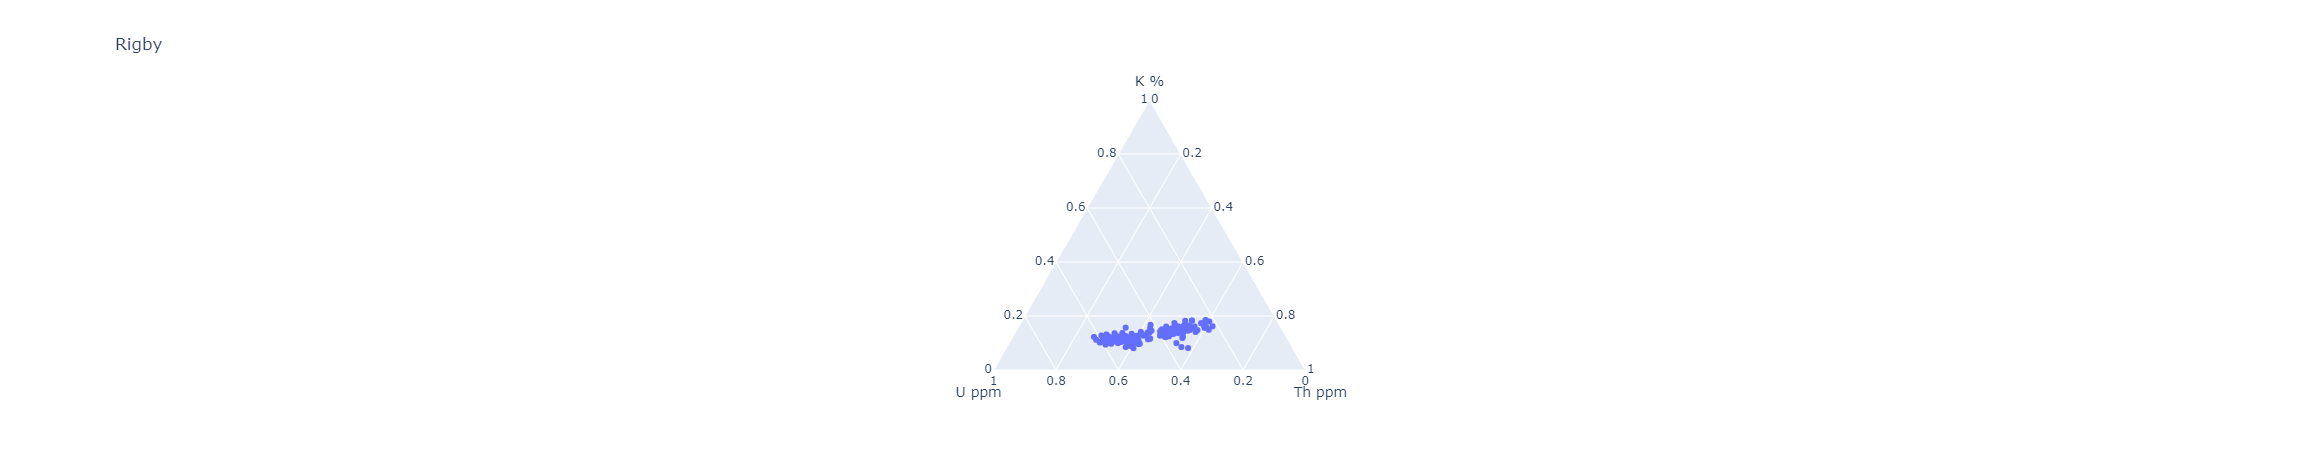

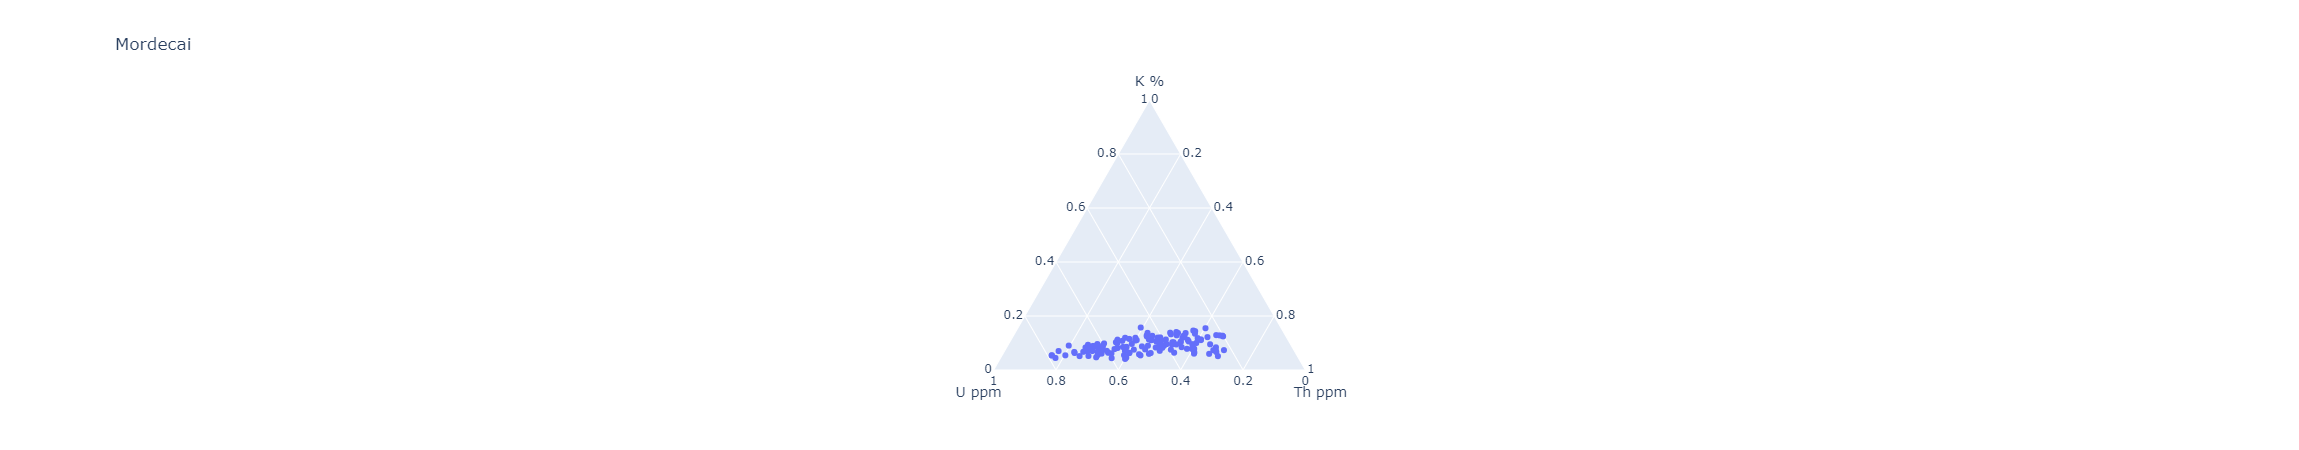

In [10]:
Ternary_Diagram(df)

In [11]:
def correlation_visualization(df, features, unit='All Data'):
    """
    Function which creates seaborn pairplots in the bottom triangle, distributions along the diagonal, and a correlation heat map along the top triangle.
    Note: If you want a pairplot of one specific formation, define unit parameter.
    """
        
    #script to hide upper axis
    def hide_current_axis(*args, **kwds):
        plt.gca().set_visible(False)
    
    if unit != 'All Data':
        df = df[df['Unit'] == unit]
    else:
        df = df
        
    pair = sns.pairplot(df[features])
    pair.map_upper(hide_current_axis)
    pair.fig.set_size_inches(5,5)
    pair.fig.suptitle('Correlation Matrix for {}'.format(unit), y=1.02, size=14)
    
    (xmin, _), (_, ymax) = pair.axes[0, 0].get_position().get_points()
    (_, ymin), (xmax, _) = pair.axes[-1, -1].get_position().get_points()
    
    ax = pair.fig.add_axes([xmin, ymin, xmax - xmin, ymax - ymin], facecolor='none')
    
    corr1 = df[features].corr()
    mask1 = np.tril(np.ones_like(corr1, dtype=bool))
    sns.heatmap(corr1, mask=mask1, cmap='coolwarm', vmax=.5, vmin=-.5,
                linewidths=.5, cbar=False, annot=True, annot_kws={'size': 12}, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([]);

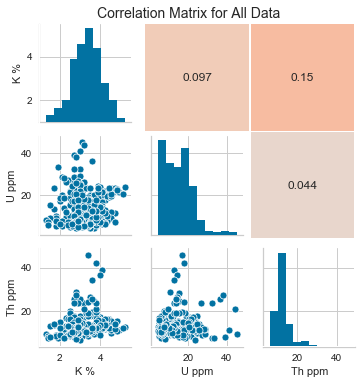

In [12]:
correlation_visualization(df, features)

<span style="color:red;font-weight:bold">!!! INPUT !!!</span>

Need to define unit names. Please change if you are using a different input file and/or add more lines and rerun the function if you have more than two units.

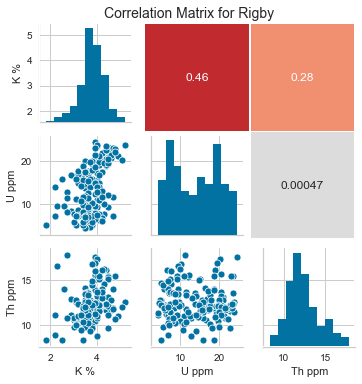

In [13]:
correlation_visualization(df, features, 'Rigby')

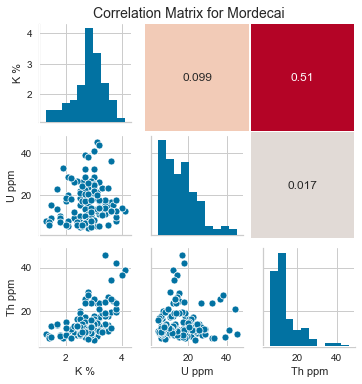

In [14]:
correlation_visualization(df, features, 'Mordecai')

**Example Explanation:**
Visually there appears to be two clear clusters in the Rigby unit ternary diagram. There also may be clusters in the Mordecai unit ternary diagram, although they are less clear. When examining the correlation matrix there appears to be weak to no correlation between the three elements for either unit, thus no variables should get a higher weight than others when clustering (which is good).

## 3. Cluster the data <a name="3"></a>
[back to top](#top)

### 3a. Determine the best number of clusters <a name="3a"></a>

**Example Explanation:**
To run KMeans clustering, an unsupervised machine learning technique, the user must define the number of clusters. To determine the optimal number of clusters, the function returns figures of three common cluster validation metrics: Elbow Method, Silhouette Coefficient, and Hierarchical Dendogram. Here is a brief description of what each metric measures:
* Elbow Method: calculates the within-cluster-sum of squared errors (WSS) for a number of clusters (k) and selects the k for which the WSS first starts to diminish.
* Silhouette Coefficient: measures how similar each point is to its assigned cluster compared to the other clusters and reports an average score (e.g. closer to 1 indicates *correct* cluster).
* Hierarchical Dendogram: although specific to agglomerative hierarchical method of clustering, it is a good visual representation of how the points cluster into groups based on distances.

In [15]:
def determine_cluster_number(df, unit):
    """
    Function returns a ternary diagram for the unit and figures for the elbow method, silhouette score, and heirarchical clustering dendogram. These are common methods for determining the optimal number of clusters for KMeans clustering.
    Note: Data is normalized using MinMaxScaler. Another common scalar is StandardScaler, which is useful for the features that follow a normal distribution.
    """
    data = df[df.Unit == unit][features] # take a slice of the dataframe
    
    # scale K, U, and Th values to give equal importance to all features
    mms = MinMaxScaler()
    mms.fit(data)
    data_transformed = mms.transform(data)

    
    # Show the ternary diagram
    # set up variables and preferences for ternary diagrams
    temp = 'ggplot2'
    
    tern = px.scatter_ternary(data, a=features[0], b=features[1], c=features[2], title=unit)
    tern.show()
    
    # KMeans is known to have a memory leak on Windows with MKL, this will ignore the warning within the script.
    import warnings
    warnings.filterwarnings(action='ignore', message="KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.")
    
    # instantiate K-means model
    model = KMeans()
    
    # create visulization for Elbow Method
    elbow = KElbowVisualizer(model, k=(1,10))
    elbow.fit(data_transformed)
    elbow.show()
    
    # create visulization for Silhouette Score
    silhouette = KElbowVisualizer(model, k=(2,14),metric='silhouette', timings= True)
    silhouette.fit(data_transformed)        # Fit the data to the visualizer
    silhouette.show()
    
    # create visulization for Heirarchical Clustering Dendrogram
    plt.figure(figsize=(10, 7))  
    plt.title("Dendrogram")  
    dendrogram = shc.dendrogram(shc.linkage(data_transformed, method='ward'), no_labels=True)

<span style="color:red;font-weight:bold">!!! INPUT !!!</span>

Add lines if you have more than two units

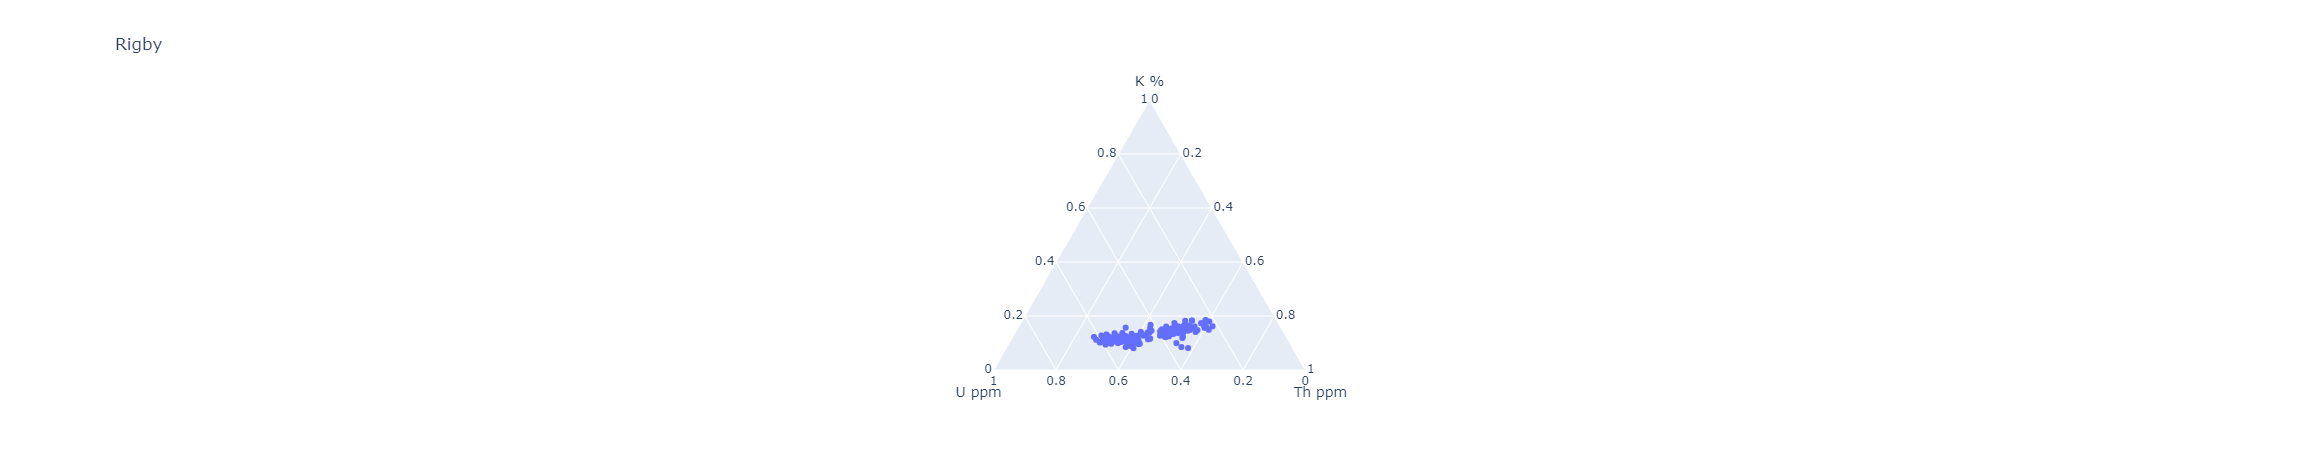

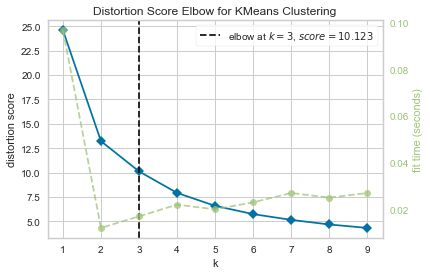

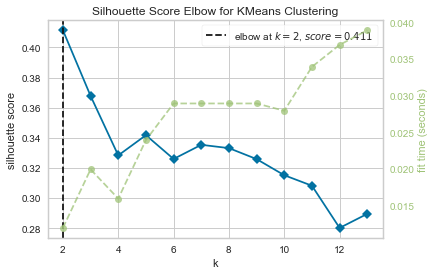

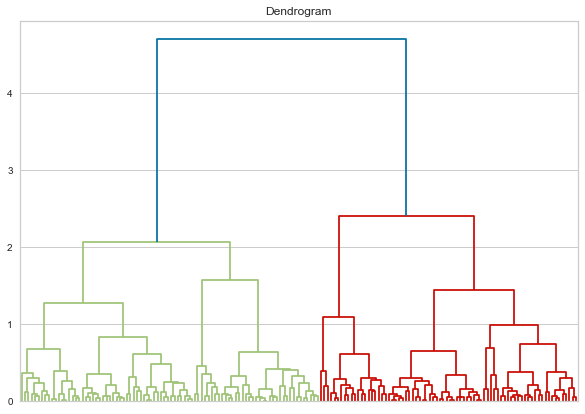

In [16]:
determine_cluster_number(df, df.Unit.unique()[0])

**Example Explanation:**
Based on the cluster validation metrics, the optimal number of clusters for the Rigby unit appears to be **2**.

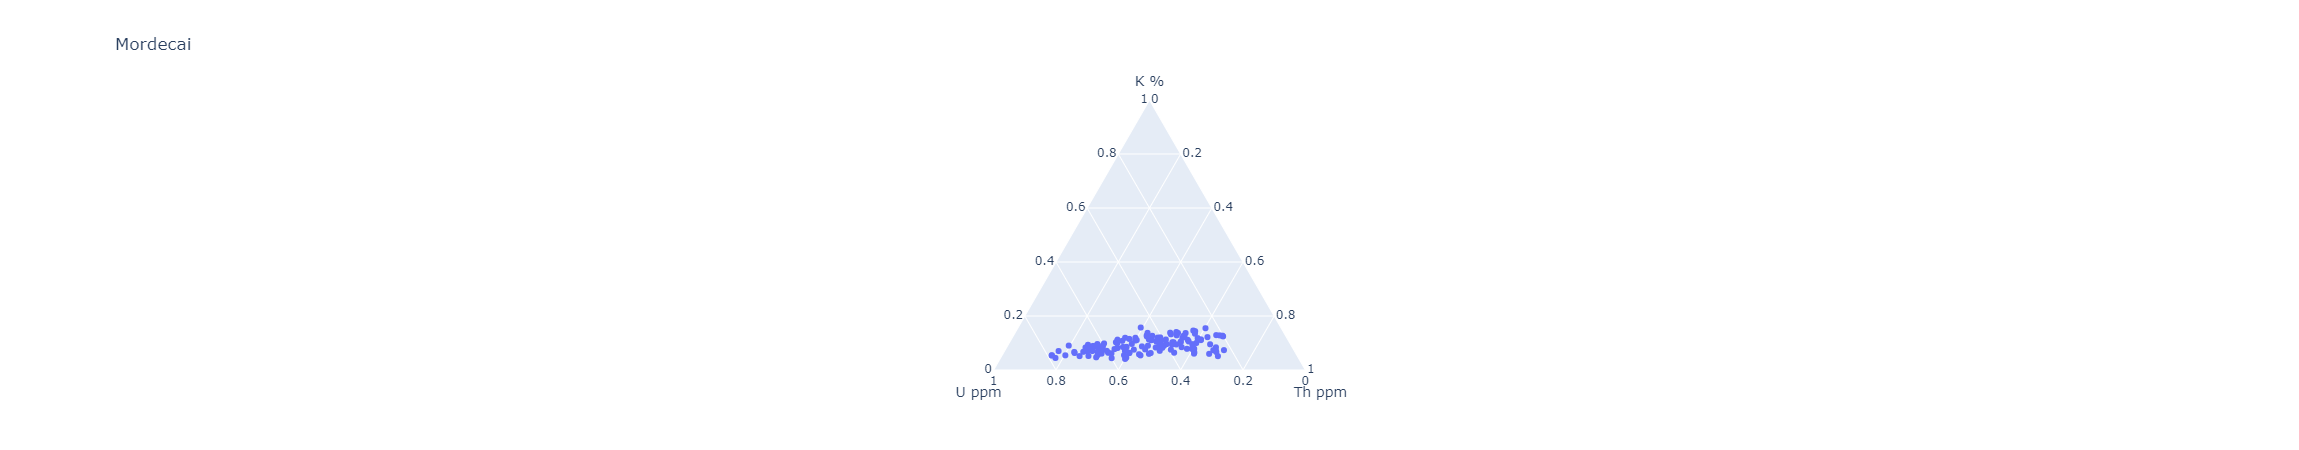

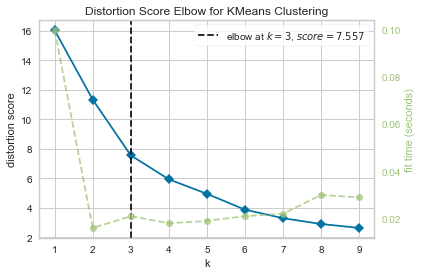

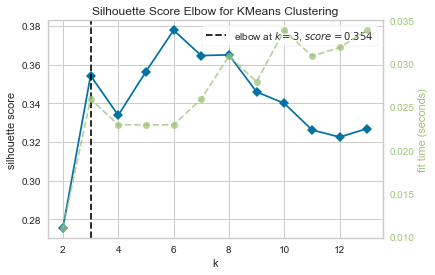

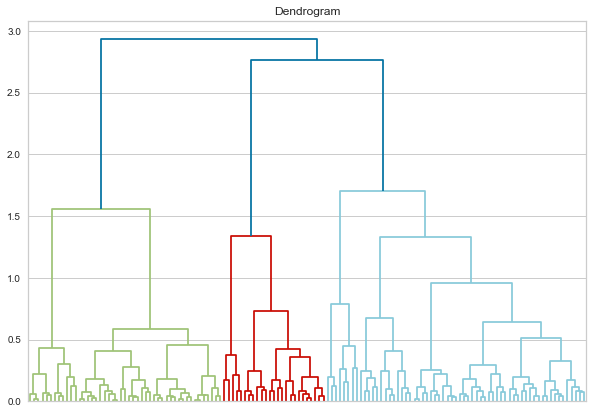

In [17]:
determine_cluster_number(df, df.Unit.unique()[1])

**Example Explanation:**
Based on the cluster validation metrics, the optimal number of clusters for the Mordecai unit appears to be **3**.

### 3b. Run KMeans Clustering <a name="3b"></a>

In [18]:
def KMeans_clustering_data(df, unit, n_clusters):
    """
    Function normalizes the data using MinMaxScaler and then runs KMeans clustering. Number of clusters and unit must be defined.
    """
    data = df[df.Unit == unit][features] # take a slice of the dataframe
    
    # scale values to give equal importance to all features
    mms = MinMaxScaler()
    mms.fit(data)
    data_transformed = mms.transform(data)
    
    kmeans = KMeans(n_clusters=n_clusters).fit(data_transformed)
    
    data['KMeans_Clusters'] = [str(num) for num in kmeans.labels_.tolist()]
    
    return data

<span style="color:red;font-weight:bold">!!! INPUT !!!</span>

Need to define unit names and number of clusters. Please change if you are using a different input file and/or add more lines and rerun the function if you have more than two units.

In [19]:
Rigby = KMeans_clustering_data(df, 'Rigby', 2)
Rigby.head()

K %  U ppm  Th ppm KMeans_Clusters
0  4.5   21.1    13.1               0
1  3.9   24.5    17.5               0
2  4.0   20.5    13.6               0
3  4.0   23.6    13.5               0
4  4.4   18.9    16.1               0

In [20]:
Mordecai = KMeans_clustering_data(df, 'Mordecai', 3)
Mordecai.head()

K %  U ppm  Th ppm KMeans_Clusters
164  2.6   26.2     9.8               2
165  2.5   22.0     9.6               2
166  2.1   20.1    11.8               0
167  2.1   28.5    10.2               2
168  3.0   41.0    11.2               2

## 4. Examine and Interpret Clusters <a name="4"></a>
[back to top](#top)

### 4a. Examine clustering <a name="4a"></a>

In [21]:
def KMeans_clustering_visualization(df, features, unit):
    """
    Function creates three visualizations which examine the clusters. 
    (1) The boxplot shows the distribution of each element across the unit and displays lines which represent each cluster's mean.
    (2) Ternary diagram with clusters visualized.
    (3) 3D diagram of the three variables so that the relationships between the variables and how they composed the clusters can be examined.
    """
       
    groups = df.groupby('KMeans_Clusters').mean()
    groups
    
    fig = px.box(pd.melt(df[features]), x='variable', y='value', color='variable', 
                 color_discrete_map={groups.columns.to_list()[0]:'#D3D3D3', groups.columns.to_list()[1]:'#D3D3D3', groups.columns.to_list()[2]:'#D3D3D3'})

    fig.update_layout(title_text=unit,
                      paper_bgcolor='rgba(255,255,255,1)',\
                      plot_bgcolor='rgba(255,255,255,1)',\
                      title_font_size=30)
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
    
    clusters = groups.index.tolist()
    clusters = [int(i) for i in clusters]
    for cluster in clusters:
        fig.add_trace(go.Scatter(x= groups.columns.to_list(), y=groups.iloc[cluster].to_list(), mode='lines', line=dict(color=px.colors.qualitative.Set1[cluster]), 
                                name=cluster))
    fig.show()
    
    temp = 'ggplot2'
    tern = px.scatter_ternary(df, a=features[0], b=features[1], c=features[2], color='KMeans_Clusters', 
                              color_discrete_sequence=px.colors.qualitative.Set1,
                              template=temp, title=unit)
    tern.show()
    
    threeD = px.scatter_3d(df, x=features[0], y=features[1], z=features[2], color='KMeans_Clusters',
                          color_discrete_sequence=px.colors.qualitative.Set1)
    threeD.show()

<span style="color:red;font-weight:bold">!!! INPUT !!!</span>

Need to define unit names. Please change if you are using a different input file and/or add more lines and rerun the function if you have more than two units.

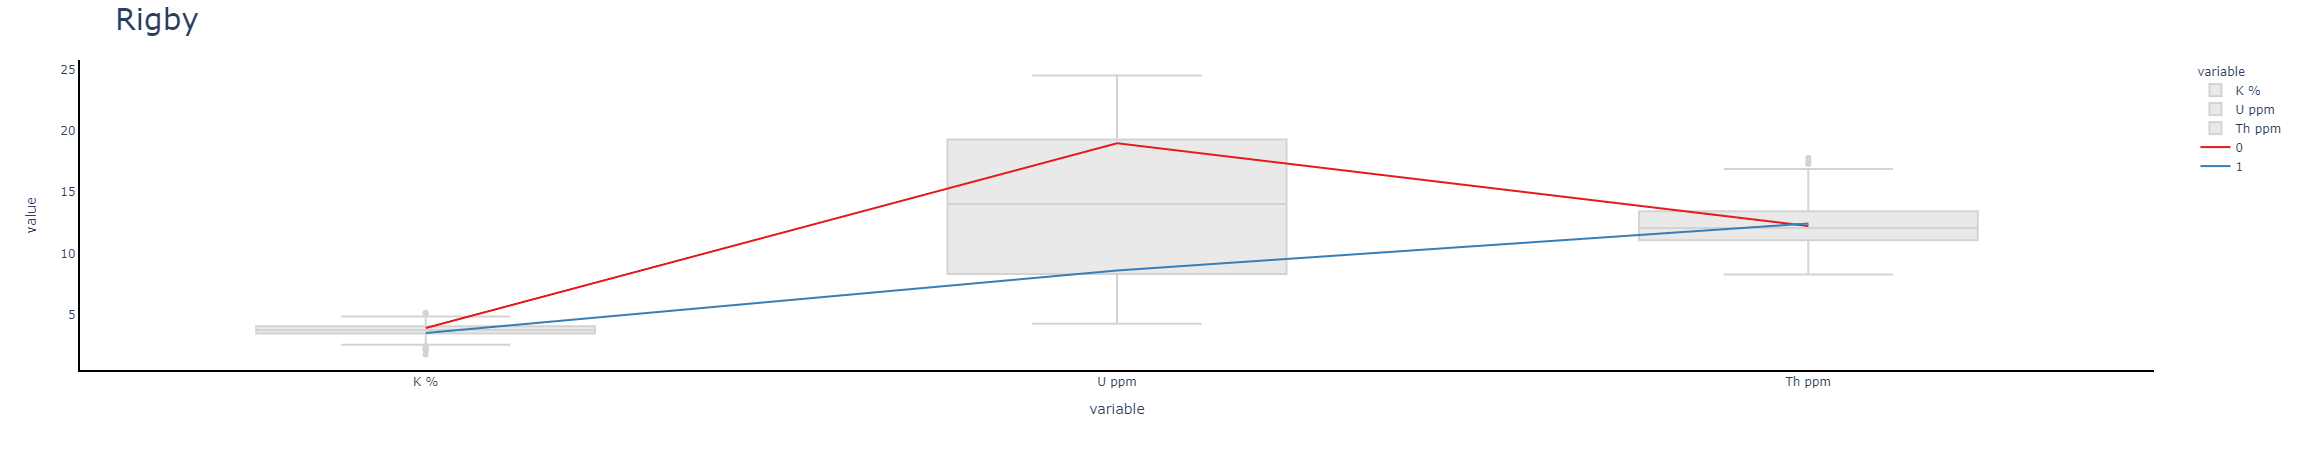

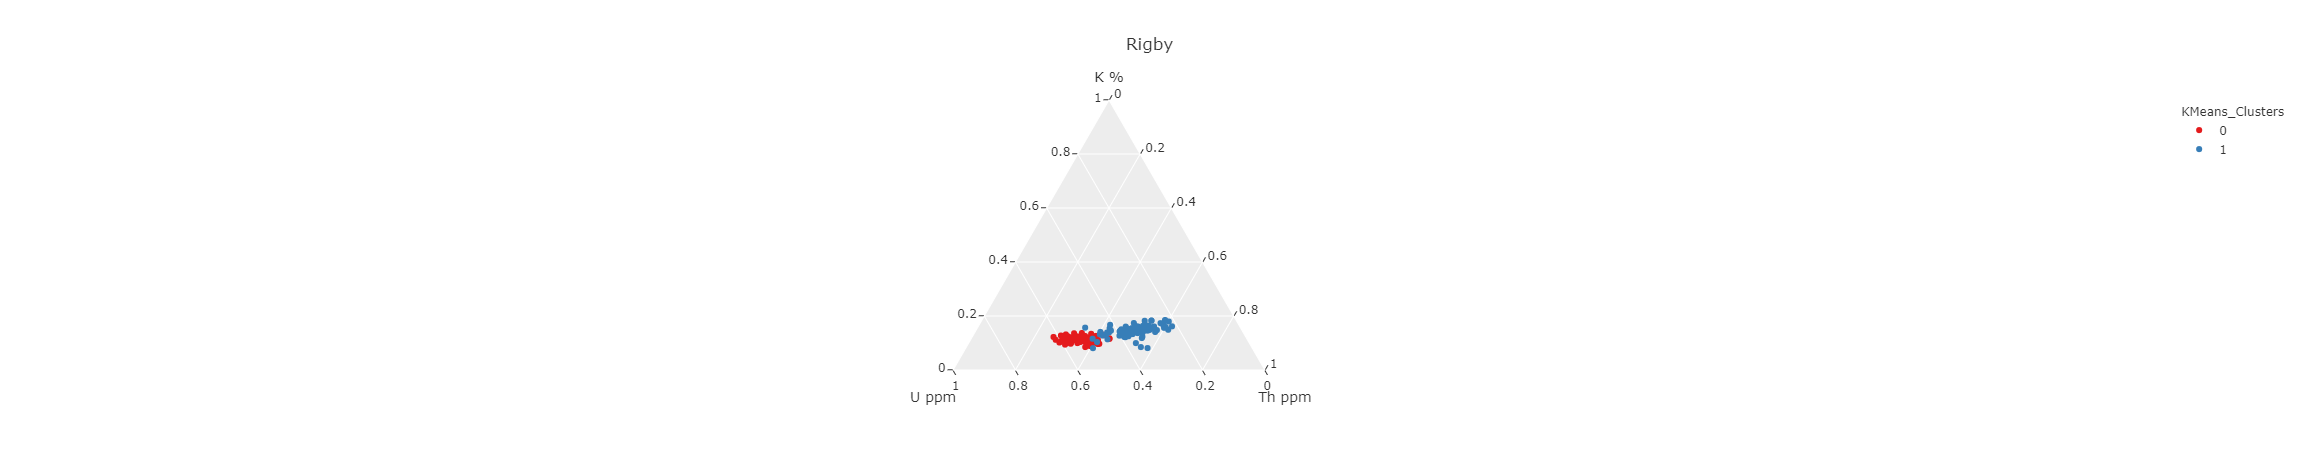

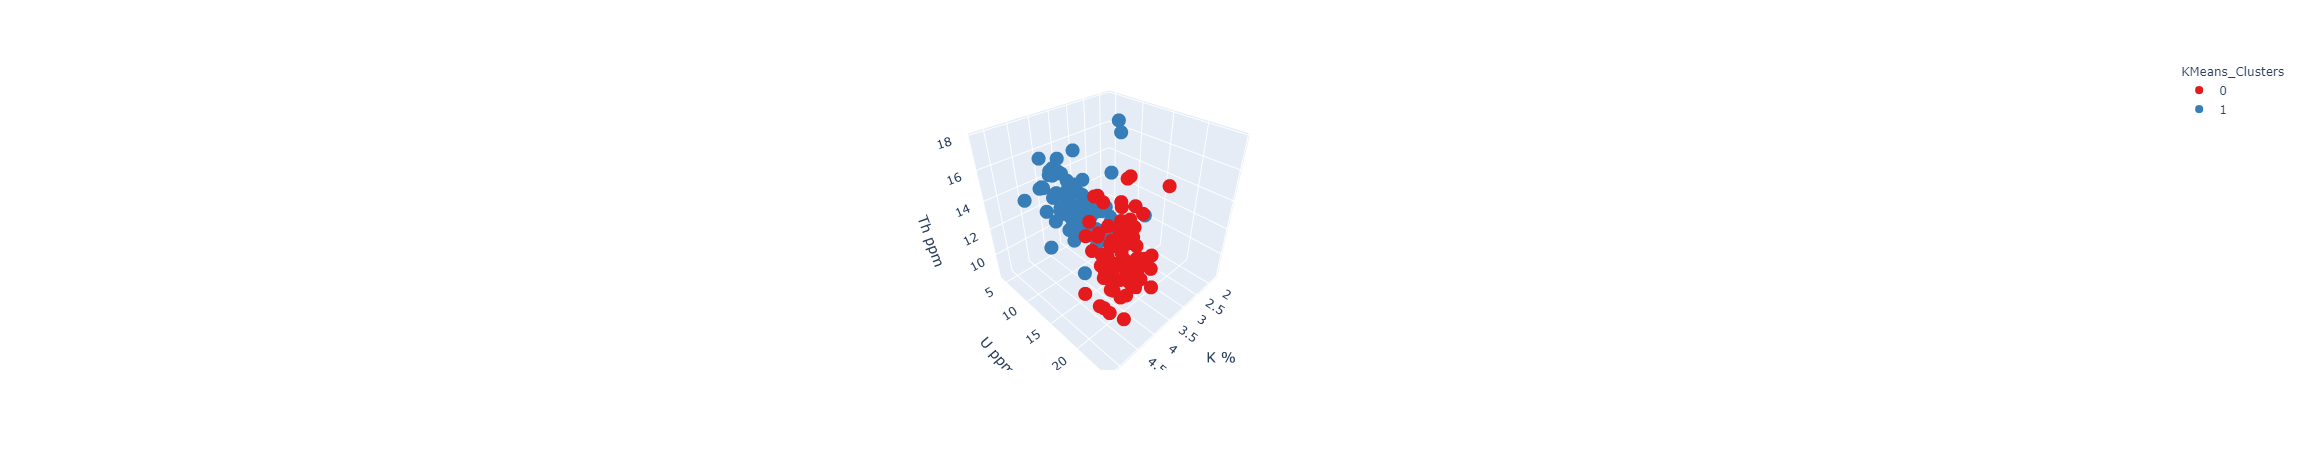

In [22]:
KMeans_clustering_visualization(Rigby, features, 'Rigby')

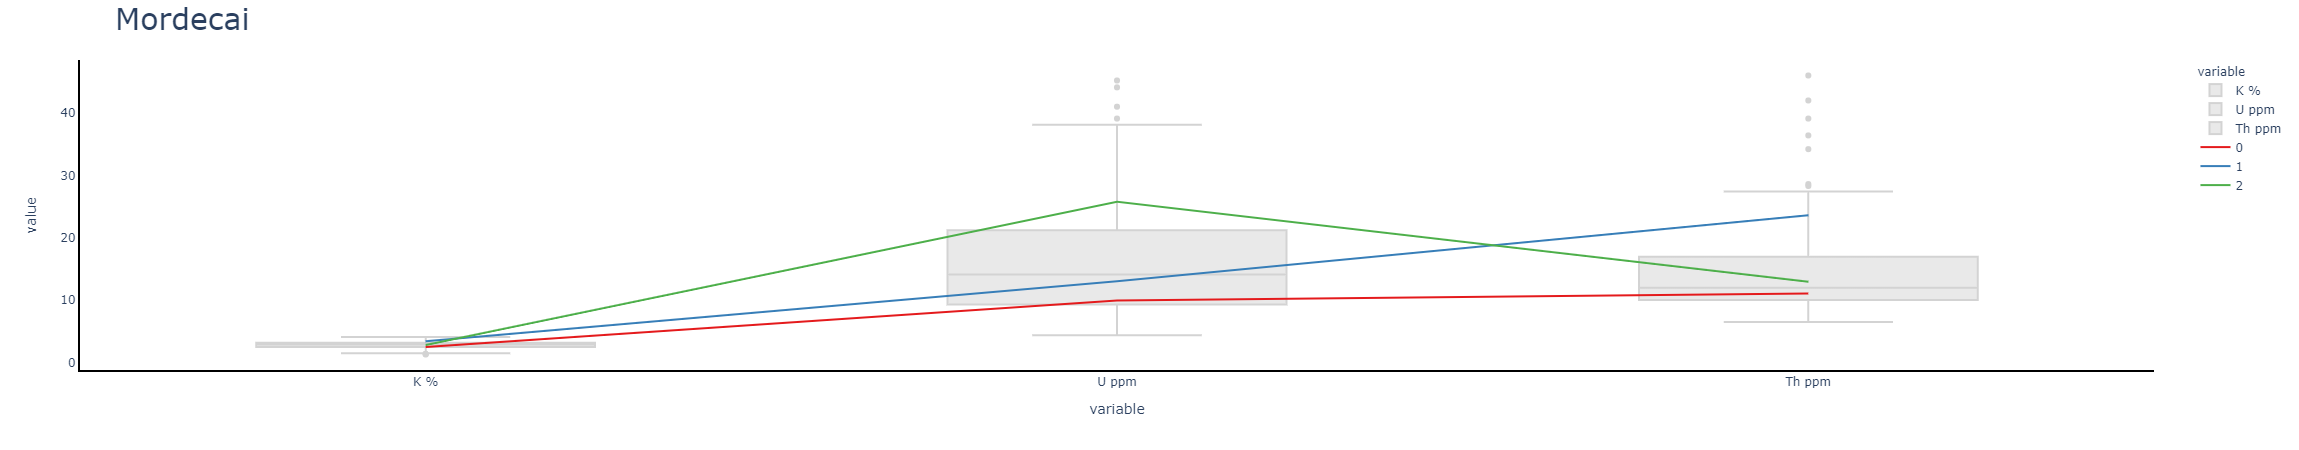

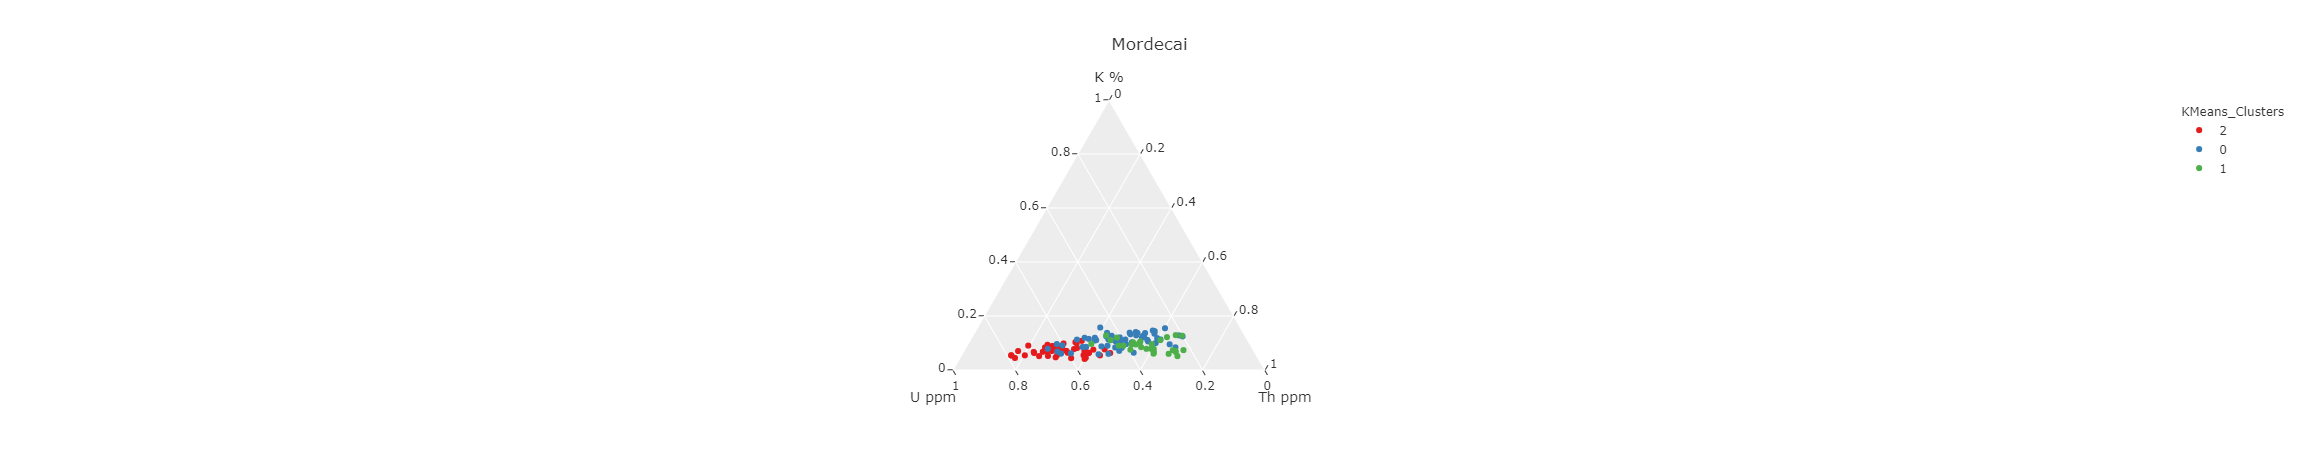

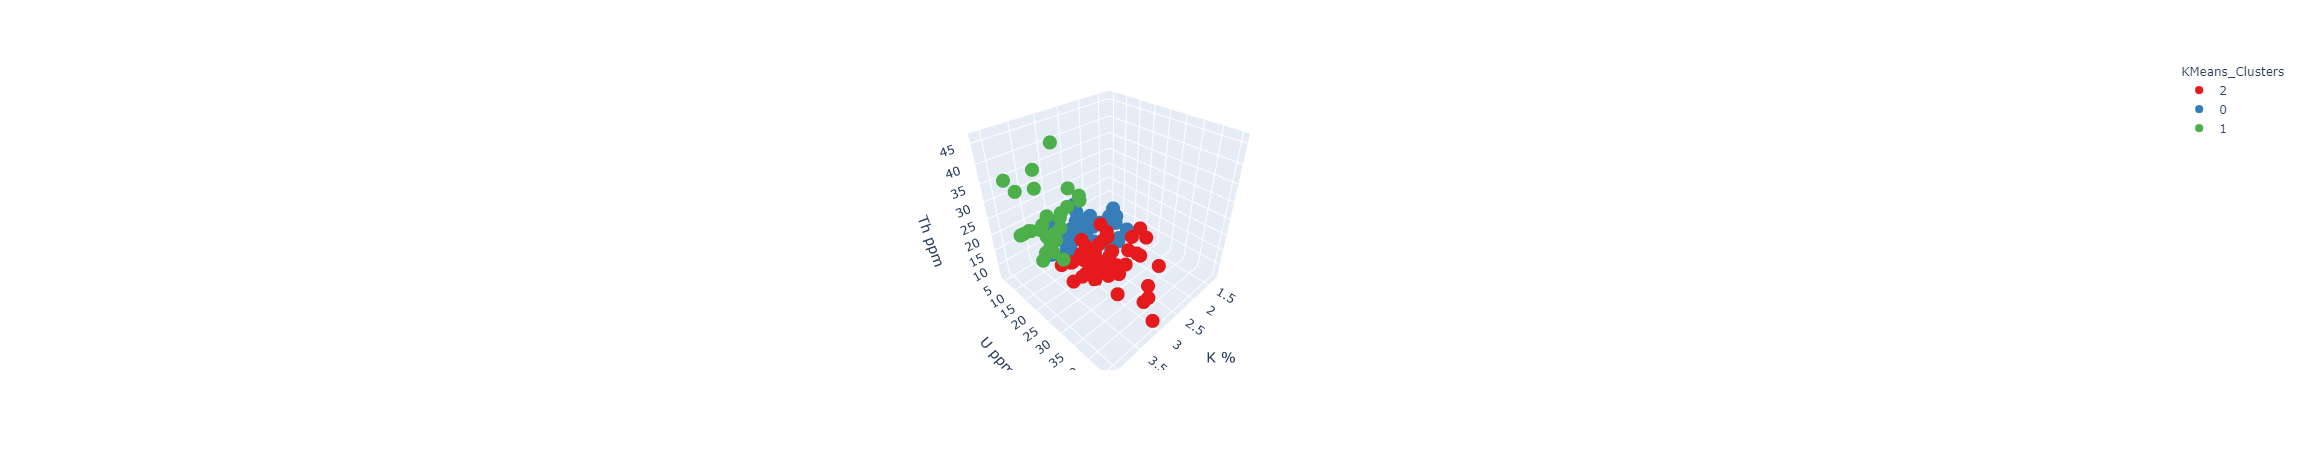

In [23]:
KMeans_clustering_visualization(Mordecai, features, 'Mordecai')

**Example Explanation:**
From the diagrams, it appears that U is an important element for clustering. Also, the interplay of K with both U and Th highlights some of the divisions between clusters.

### 4b. PCA to examine feature importance <a name="4b"></a>

**Example Explanation:**
PCA was used as another way to quantify and identify the importance of each feature (e.g. the magnitude of the absolute values of the eigenvector's components), quantify the amount of variance explained within the K, U, Th data, and further examine the interplay between the variables.

In [24]:
def PCA_plot_and_info(df, features):
    """
    Function normalizes the data using MinMaxScaler and then runs PCA for 2 components. 
    Function returns a table of the magnitude of the absolute values of the eigenvector's components and the amount of variance explained by each principal component.
    """
    
    # scale values to give equal importance to all features
    mms = MinMaxScaler()
    mms.fit(df[features])
    data_transformed = mms.transform(df[features])
    
    y=np.array([int(i) for i in df['KMeans_Clusters'].tolist()])
    
    pca = PCA(n_components=2)
    x_new = pca.fit_transform(data_transformed)
    
    score = x_new[:,0:2]
    coeff = np.transpose(pca.components_[0:2,:])
    
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
    
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(6,6), dpi=100)
    classes = np.unique(y)
    colors = ['r','b','g','y','c']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l], ys[y==l], c=colors[s]) # color based on group
    for i in range(n):
        # plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0,0, coeff[i,0]*.8, coeff[i,1]*.8, color='k', alpha=0.5, linestyle='-', linewidth=1.5, overhang=0.2)
        plt.text(coeff[i,0]*.86, coeff[i,1]*.86, features[i], color='k', ha='center', va='center', fontsize=10)
    plt.xlabel('PC{}'.format(1), size=12)
    plt.ylabel('PC{}'.format(2), size=12)
    limx = int(xs.max()) + 1
    limy = int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=12)
    
    print('Eigenvector and Explained Variance Ratio for each componet:')
    eigen = pd.DataFrame(abs(pca.components_), columns=features, index=['PC1','PC2'])
    ex_var_rat = pd.DataFrame(pca.explained_variance_ratio_, index=['PC1','PC2'], columns=['Explained_Variance_Ratio'])
    print(pd.concat([eigen, ex_var_rat], axis=1))

Eigenvector and Explained Variance Ratio for each componet:
          K %     U ppm    Th ppm  Explained_Variance_Ratio
PC1  0.333052  0.940893  0.061616                  0.602037
PC2  0.299679  0.167584  0.939206                  0.289267


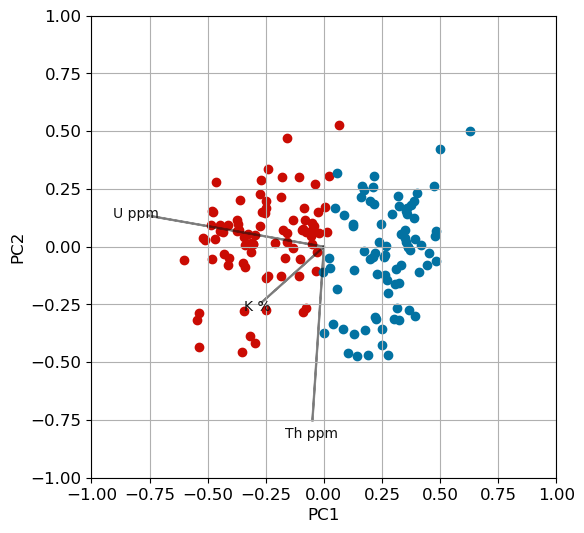

In [25]:
PCA_plot_and_info(Rigby, features)

**Example Explanation:**
Within the Rigby unit, PC1 explains 60% of the variance and U ppm is the most important influence. PC2 explains ~30% of the variance and Th ppm is the most important influence followed by K %.

Eigenvector and Explained Variance Ratio for each componet:
          K %     U ppm    Th ppm  Explained_Variance_Ratio
PC1  0.733769  0.353872  0.579964                  0.474591
PC2  0.226728  0.932249  0.281968                  0.380544


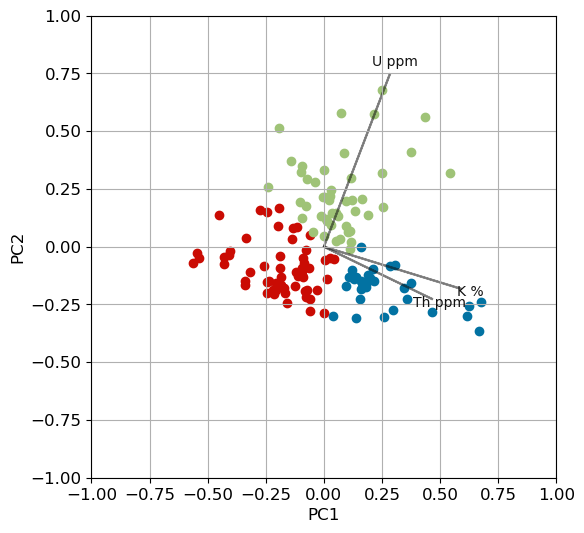

In [26]:
PCA_plot_and_info(Mordecai, features)

**Example Explanation:**
Within the Mordecai unit, PC1 explains 47% of the variance and is related to the relationships between K % and Th ppm. PC2 explains 38% of the variance and U ppm is the most important influence.

## 5. Conclusions <a name="5"></a>
[back to top](#top)

**What statistical techniques have you used and what were the specific applications? Why did you select those techniques?**

In the submitted code, I have used descriptive statistics, 2D and 3D visualization, KMeans clustering with cluster validation metrics, and principal component analysis (PCA). I used these techniques to examine the relationships between potassium (K %), uranium (U ppm), and thorium (Th pmm) from two mudstone units, as well as determine if there are clusters within each unit. Descriptive statistics were used to provide a summary of the central tendency, dispersion, and shape of the dataset and, since geologists are commonly visual learners, I also included visualizations of correlation, the pairwise relationships in the dataset, and the distribution of each variable. I selected KMeans clustering because it is a robust, efficient method to separate samples into groups for preliminary analysis and because there are several easy to understand cluster validation metrics to aid in determining the optimal number of clusters. The geologist that provided the data was especially interested in examining the relationships between the three elements (K, U, and Th). To better quantify the elements’ relationships, I used PCA to further understand the results of KMeans clustering, determine feature importance (i.e. the magnitude of the absolute values of the eigenvector components), and visualize feature relationships in two dimensions. Although the following techniques were not applied in this script, I am also familiar with other clustering methods (e.g. DBSCAN), applying spatial clustering techniques in ArcGIS, using linear regression to predict dependent variables, and classifying core samples using random forests.